In [20]:
import serial
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd
import time

from DriveTrain import DriveTrain

In [21]:
# load the driveshaft class
drivetrain = DriveTrain()
drivetrain.print()

Drive Train: Pinion:  15.0 T
Drive Train: Spur:  46.0 T
Drive Train: Differential Ratio:  2.8
Drive Train: Final Drive Ratio:  8.586666666666666 : 1 (Motor Rotations:Wheel Rotation)
Drive Train: Tire Diameter:  0.1  m
Drive Train: Tire Circumference:  0.3141592653589793  m


In [22]:
header_i = 0
steve_time_i = 1
xavier_time_i = 2
cmd_status_flag_i = 3
steve_cntrl_cmd_i = 4
steve_speed_cmd_i = 5
steve_steer_cmd_i = 6
xavier_status_flag_i = 7
xaiver_speed_cmd_i = 8
xaiver_steer_cmd_i = 9
he_current_time_i = 10
he_dt_i = 11
trailer_i = 12

Auto-Calibration Routine
1. Manual-calibrate steering
    1. set steering to preset values and measure by hand
    2. Manually enter the measured angle 
    3. Plot to estimate form of function
    4. Regression to optimize function for fit 
2. Auto-Calibrate Power
    1. Set throttle values
    2. Measure driveshaft speed from encoder
    3. Plot to estimate function
    4. Regression to optimize function for fit

In [4]:
# Manual Calibrate steering
# 1. Send angle to the Arduino
def send_and_hold_steering_cmd(steer_cmd, hold_time=5, port='COM22'):

    header='C'
    tailer='$'
    speed_cmd = 1500
    checksum_mod = 1000

    # Initialize the serial port (replace 'COM7' with the appropriate port)
    s_port = serial.Serial(port, 115200)
    

    cmd = header + "," + str(steer_cmd) + "," + str(speed_cmd) + "," + str((speed_cmd + steer_cmd) % checksum_mod) + "," + tailer
    s_port.write(cmd.encode('utf-8'))

    ss = []

    s_time = time.time()
    while time.time() - s_time < hold_time:
        s = s_port.readline().decode().strip()
        if s[0] == header and s[-1] == tailer:
            ss.append(s)
            s_split = s.split(',')
            # print(f"s_split: {s_split}")
            print(f"{time.time()-s_time:.1f} xaiver_steer_cmd_i: {s_split[xaiver_steer_cmd_i]}")
        s_port.write(cmd.encode('utf-8'))
        
    s_port.close()
        
send_and_hold_steering_cmd(1600, 5)
send_and_hold_steering_cmd(1500, 0.1)

0.0 xaiver_steer_cmd_i: 1500
0.1 xaiver_steer_cmd_i: 1600
0.1 xaiver_steer_cmd_i: 1600
0.2 xaiver_steer_cmd_i: 1600
0.2 xaiver_steer_cmd_i: 1600
0.3 xaiver_steer_cmd_i: 1600
0.3 xaiver_steer_cmd_i: 1600
0.4 xaiver_steer_cmd_i: 1600
0.4 xaiver_steer_cmd_i: 1600
0.5 xaiver_steer_cmd_i: 1600
0.5 xaiver_steer_cmd_i: 1600
0.6 xaiver_steer_cmd_i: 1600
0.6 xaiver_steer_cmd_i: 1600
0.7 xaiver_steer_cmd_i: 1600
0.8 xaiver_steer_cmd_i: 1600
0.8 xaiver_steer_cmd_i: 1600
0.9 xaiver_steer_cmd_i: 1600
0.9 xaiver_steer_cmd_i: 1600
1.0 xaiver_steer_cmd_i: 1600
1.0 xaiver_steer_cmd_i: 1600
1.1 xaiver_steer_cmd_i: 1600
1.1 xaiver_steer_cmd_i: 1600
1.2 xaiver_steer_cmd_i: 1600
1.2 xaiver_steer_cmd_i: 1600
1.3 xaiver_steer_cmd_i: 1600
1.3 xaiver_steer_cmd_i: 1600
1.4 xaiver_steer_cmd_i: 1600
1.4 xaiver_steer_cmd_i: 1600
1.5 xaiver_steer_cmd_i: 1600
1.5 xaiver_steer_cmd_i: 1600
1.6 xaiver_steer_cmd_i: 1600
1.6 xaiver_steer_cmd_i: 1600
1.7 xaiver_steer_cmd_i: 1600
1.7 xaiver_steer_cmd_i: 1600
1.8 xaiver_ste

lr.estimator_.coef_: [[0.09642857]]
lr.estimator_.intercept_: [-145.]
y=mx+b : y=0.09642857142857139x+-144.99999999999994
[ -0.35714286   9.28571429   4.46428571  14.10714286  -5.17857143
 -10.         -14.82142857]


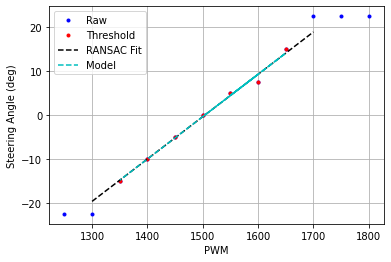

In [5]:
# Important Note - angles are ALWAYS inner wheel
pwms = [1500, 1600, 1700, 1800, 1550, 1650, 1750, 1450, 1400, 1350, 1300., 1250.]
angs = [0.0, 7.5, 22.5, 22.5, 5., 15.0, 22.5, -5., -10., -15., -22.5, -22.5]

plt.plot(pwms, angs, 'b.', label='Raw')
plt.xlabel('PWM')
plt.ylabel('Steering Angle (deg)')

thresh_pwms = [value for index, value in enumerate(pwms) if value > 1300 and value < 1700]
thresh_angs = [angs[index] for index, value in enumerate(pwms) if value > 1300 and value < 1700]

lr = linear_model.RANSACRegressor()
lr.fit(np.array(thresh_pwms).reshape(-1, 1), np.array(thresh_angs).reshape(-1, 1))

line_x = np.linspace(1300, 1700, 100)
line_y = lr.predict(np.array(line_x).reshape(-1, 1))

print(f"lr.estimator_.coef_: {lr.estimator_.coef_}")
m = lr.estimator_.coef_[0][0]
print(f"lr.estimator_.intercept_: {lr.estimator_.intercept_}")
b = lr.estimator_.intercept_[0]
print(F"y=mx+b : y={m}x+{b}")


est_angs = m * np.array(thresh_pwms) + b
print(est_angs)

plt.plot(thresh_pwms, thresh_angs, 'r.', label='Threshold')
plt.plot(line_x, line_y, 'k--', label='RANSAC Fit')
plt.plot(thresh_pwms, est_angs, 'c--', label='Model')
plt.xlabel('PWM')
plt.ylabel('Steering Angle (deg)')
plt.legend()
plt.grid()
plt.show()


In [6]:
def send_and_hold_steering_angle(steer_angle, hold_time=5, port='COM22'):
    header='C'
    tailer='$'
    speed_cmd = 1500
    checksum_mod = 1000

    # Initialize the serial port (replace 'COM7' with the appropriate port)
    s_port = serial.Serial(port, 115200)
    
    steer_cmd = (steer_angle - b) / m
    print(f"steer_cmd: {steer_cmd}")
    cmd = header + "," + str(steer_cmd) + "," + str(speed_cmd) + "," + str((speed_cmd + steer_cmd) % checksum_mod) + "," + tailer
    s_port.write(cmd.encode('utf-8'))

    ss = []

    s_time = time.time()
    while time.time() - s_time < hold_time:
        s = s_port.readline().decode().strip()
        if s[0] == header and s[-1] == tailer:
            ss.append(s)
            s_split = s.split(',')
            # print(f"s_split: {s_split}")
            print(f"{time.time()-s_time:.1f} xaiver_steer_cmd_i: {s_split[xaiver_steer_cmd_i]}")
        s_port.write(cmd.encode('utf-8'))
    s_port.close()
    
send_and_hold_steering_angle(20, 3)
send_and_hold_steering_angle(0, 0.1)

steer_cmd: 1711.111111111111
0.0 xaiver_steer_cmd_i: 1500
0.1 xaiver_steer_cmd_i: 1711
0.1 xaiver_steer_cmd_i: 1711
0.2 xaiver_steer_cmd_i: 1711
0.2 xaiver_steer_cmd_i: 1711
0.3 xaiver_steer_cmd_i: 1711
0.3 xaiver_steer_cmd_i: 1711
0.4 xaiver_steer_cmd_i: 1711
0.4 xaiver_steer_cmd_i: 1711
0.5 xaiver_steer_cmd_i: 1711
0.5 xaiver_steer_cmd_i: 1711
0.6 xaiver_steer_cmd_i: 1711
0.6 xaiver_steer_cmd_i: 1711
0.7 xaiver_steer_cmd_i: 1711
0.7 xaiver_steer_cmd_i: 1711
0.8 xaiver_steer_cmd_i: 1711
0.8 xaiver_steer_cmd_i: 1711
0.9 xaiver_steer_cmd_i: 1711
0.9 xaiver_steer_cmd_i: 1711
1.0 xaiver_steer_cmd_i: 1711
1.1 xaiver_steer_cmd_i: 1711
1.1 xaiver_steer_cmd_i: 1711
1.2 xaiver_steer_cmd_i: 1711
1.2 xaiver_steer_cmd_i: 1711
1.3 xaiver_steer_cmd_i: 1711
1.3 xaiver_steer_cmd_i: 1711
1.4 xaiver_steer_cmd_i: 1711
1.4 xaiver_steer_cmd_i: 1711
1.5 xaiver_steer_cmd_i: 1711
1.5 xaiver_steer_cmd_i: 1711
1.6 xaiver_steer_cmd_i: 1711
1.6 xaiver_steer_cmd_i: 1711
1.7 xaiver_steer_cmd_i: 1711
1.7 xaiver_ste

In [7]:
# Manual Calibrate steering
# 1. Send angle to the Arduino
dts = []
ts = []
lts = []

def send_and_hold_speed_cmd(speed_cmd, hold_time=5, port='COM22'):

    header='C'
    tailer='$'
    steer_cmd = 1500
    checksum_mod = 1000

    # Initialize the serial port (replace 'COM7' with the appropriate port)
    s_port = serial.Serial(port, 115200)
    

    cmd = header + "," + str(steer_cmd) + "," + str(speed_cmd) + "," + str((speed_cmd + steer_cmd) % checksum_mod) + "," + tailer
    s_port.write(cmd.encode('utf-8'))

    ss = []

    s_time = time.time()
    while time.time() - s_time < hold_time:
        s = s_port.readline().decode().strip()
        if s[0] == header and s[-1] == tailer:
            ss.append(s)
            s_split = s.split(',')
            # print(f"s_split: {s_split}")
            # print(f"{time.time()-s_time:.1f} xaiver_speed_cmd_i: {s_split[xaiver_steer_cmd_i]}")
            # print(f"{time.time()-s_time:.1f} he_dt_i: {s_split[he_dt_i]}")
            ts.append(time.time())
            dts.append(60000000./float(s_split[he_dt_i]))
            lts.append(float(s_split[he_current_time_i]))
            # dts.append(s_split[he_current_time_i])
            # print(f"{time.time()-s_time:.1f} rpm: {60000000./float(s_split[he_dt_i])}")
        s_port.write(cmd.encode('utf-8'))
        
    s_port.close()

for _ in range(5):
    send_and_hold_speed_cmd(1550, 8)
    print(f"mean: {np.mean(dts[-100:])} and variance: {np.var(dts[-100:])}")
    send_and_hold_speed_cmd(1500, 1.0)

mean: 304.48506500756133 and variance: 3.2311742677852644e-27
mean: 304.48506500756133 and variance: 3.2311742677852644e-27
mean: 304.48506500756133 and variance: 3.2311742677852644e-27
mean: 304.48506500756133 and variance: 3.2311742677852644e-27
mean: 304.48506500756133 and variance: 3.2311742677852644e-27


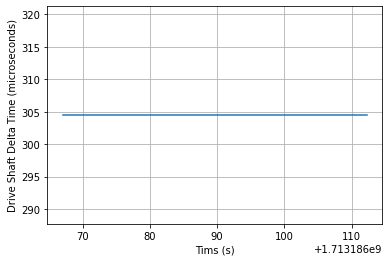

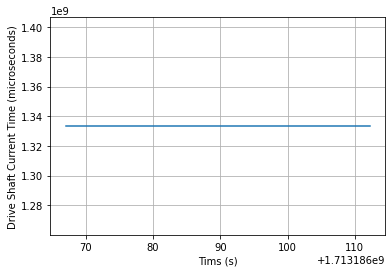

In [8]:
plt.plot(ts, dts)
plt.grid()
plt.xlabel("Tims (s)")
plt.ylabel("Drive Shaft Delta Time (microseconds)")
plt.show()

plt.plot(ts, lts)
plt.grid()
plt.xlabel("Tims (s)")
plt.ylabel("Drive Shaft Current Time (microseconds)")
plt.show()
# print("dts: ", dts)

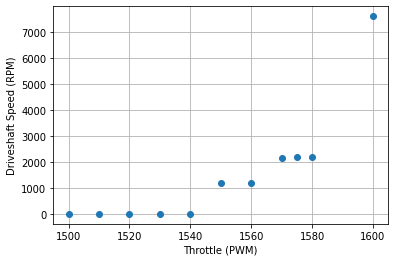

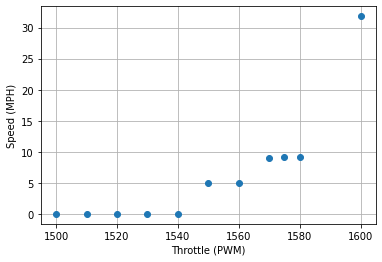

In [9]:
speed_data = np.array([[1500, 0., 0.],
                       [1510, 0., 0.],
                       [1520, 0., 0.],
                       [1530, 0., 0.],
                       [1540, 0., 0.],
                       [1550,  1171.268481045635,  31.20199052394689],
                       [1560, 1172.341266943733,   26.947816740098162],
                       [1570, 2147.2698615606773, 998.5076495574136],
                       [1575, 2177.6237089676456, 304.76718308091915],
                       [1580, 2175.518636319908,  345.9189577672784],
                       [1600, 7607.105330020181, 1513.2370220055684]])

plt.plot(speed_data[:,0], speed_data[:,1], 'o')
plt.xlabel("Throttle (PWM)")
plt.ylabel("Driveshaft Speed (RPM)")
plt.grid()
plt.show()

speeds_mph = drivetrain.calc_car_speed_mph_from_driveshaft_rpm(speed_data[:,1])
plt.plot(speed_data[:,0], speeds_mph, 'o')
plt.xlabel("Throttle (PWM)")
plt.ylabel("Speed (MPH)")
plt.grid()
plt.show()

plt.plot(speed_data[:,1], speeds_mph, 'o')
plt.xlabel("Throttle (PWM)")
plt.ylabel("Speed (MPH)")
plt.grid()
plt.show()

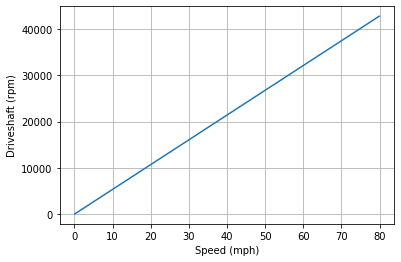

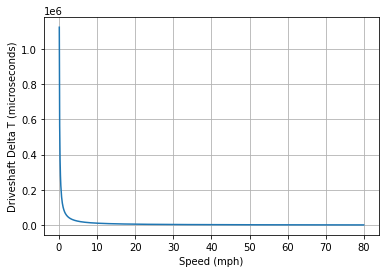

min speed of 0.1 mph = 1121997.376282069 microseconds
max speed of 79.9 mph = 1404.2520353968323 microseconds


In [32]:
ss = []
rs = []
ds = []

for s in range(1, 800):
    speed_mph = s/10.
    ss.append(speed_mph)
    # print(f"Speed MPH: {speed_mph}")
    ds_rpm = drivetrain.calc_driveshaft_rpm_from_car_speed_mps(speed_mph)
    rs.append(ds_rpm)
    # print(f"driveshaft rpm: {ds_rpm}")
    ds_dt = 10.**6 / (ds_rpm / 60.)
    ds.append(ds_dt)
    # print(f"HE dt: {ds_dt}")
    
plt.plot(ss, rs)
plt.xlabel("Speed (mph)")
plt.ylabel("Driveshaft (rpm)")
plt.grid()
plt.show()

plt.plot(ss, ds)
plt.xlabel("Speed (mph)")
plt.ylabel("Driveshaft Delta T (microseconds)")
plt.grid()
plt.show()

print(f"min speed of {ss[0]} mph = {ds[0]} microseconds")
print(f"max speed of {ss[-1]} mph = {ds[-1]} microseconds")